## Optimization

SciPy의 최적화 모듈인 ```optimize``` 모듈에 대해 알아본다.  

이 모듈은 objective function을 최소화하는 방법들을 제공한다.

In [1]:
from scipy import optimize

In [2]:
import cvxopt

In [3]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import matplotlib

수학적 최적화의 문제는 다음의 최소화 문제로 표현된다.

$$ \min_x f(x) \quad \text{subject to } g(x) = 0 \text{ and } h(x) \leq 0 $$

여기서 $g$와 $h$의 제약 조건은 여러 개가 가능하며, 일반적으로 vector-valued function으로 표현된다.

반면 $f$는 scalar-valued function이다.

$x$는 one-dimensional 혹은 multi-dimensional일 수 있는데, dimension이 높아질수록 문제는 어려워진다.  

만약 $f, g, h$가 모두 선형 함수이면, 최적화 문제는 linear programming 문제라 하고,  어느 하나라도 선형 함수가 아니면, nonlinear programming 문제라고 한다.  

Nonlinear programming은 해결하기 어려운 경우가 많으며, global minima와 local minima를 구분하기 어려울 수 있다.  

Nonlinear programming 중 convex problem은 특수한 케이스로서 global minima를 비교적 효율적으로 찾을 수 있다. 

Continuous하고 smooth한 objective function $f$의 optimization 문제는 다음의 문제를 해결하는 것과 비슷하다.

$$ \nabla f(x) = 0 $$

위 조건을 만족하도록 찾아진 $x^*$은 minimum, maximum, saddle point 중 하나이며, 이 중 minimum을 찾기 위해서는, $x^*$에서 계산된 Hessian matrix가 positive definite이어야 한다.

Hessian matrix는 다음과 같이 계산한다.

$$ \{ H_f(x) \}_{ij} = \frac{\partial^2 f(x)}{\partial x_i \partial x_j} $$

하지만 많은 경우 $ \nabla f(x) = 0 $의 해를 찾는 것이 간단하지 않다.   

이를 위해서는 최적화를 위해 고안된 수치적 방법을 이용한다. 

수치적 방법에서는 초기값 $x_0$로부터 시작해 $x_0 \rightarrow x_1 \rightarrow x_2 \rightarrow \cdots $로 점진적으로 이동해 가며 최소값의 위치를 찾는다.

### Overview of algorithms

함수의 mininum을 찾는 수치적인 최적화 알고리즘은 크게 line search와 trust region 방법으로 구분할 수 있다.

#### line search

Line search 방법은 어떤 위치 $x_k$에서 나아갈 방향 $p_k$를 먼저 찾은 후, 그 방향으로 이동할 최적화된 step size $\alpha$를 찾아 다음 $x_{k+1}$로 이동하는 방법이다.

방향 $p$를 찾는 방법으로는 steepest descent, Newton method, quasi-Newton method, conjugate gradient method 등이 있다.

* steepest descent는 음의 gradient, $-\nabla f$를 이동 방향으로 삼는다. 복잡한 문제에서 느리다는 단점이 있다.

* Newton 방법에서는 $ - H_f^{-1}  \nabla f $를 이동 방향으로 삼는다. 

* Quasi-Newton method에서는 Hessian을 근사하여 계산한다. 
  * 자주 쓰는 방법으로 symmetric-rank-one(SR1), Broyden-Fletcher-Goldfarb-Shanno(BFGS) 방법이 있다.

* Conjugate gradient method는 steepest descent처럼 $-\nabla f$를 이용하나, conjugate vector로 방향을 보완하여 효율성을 높인 방법


#### trust region

Trust region 방법은 $x_k$ 근방에서 $f$를 근사하는 $m_k$를 만들고 충분히 근사되는 $x_k$의 적절한 근방에서 $m_k$의 최소값 위치를 찾는 방법이다.

### Univariate optimization

일변량 함수의 optimization 문제는 비교적 간단하다.  

다음 예제에서는 단위 부피를 가지는 원기둥의 겉넓이를 최소화하는 문제를 다루어 본다.

먼저 알려진 수학적 지식을 이용하여 직접 풀어보자.  

In [4]:
r, h = sympy.symbols("r, h")
Area = 2 * sympy.pi * r**2 + 2 * sympy.pi * r * h
Volume = sympy.pi * r**2 * h

```Volume == 1```이 되도록 하는 ```h```를 ```r```에 대한 표현식으로 찾는다.

In [5]:
sympy.solve(Volume - 1, h)

[1/(pi*r**2)]

In [6]:
h_r = sympy.solve(Volume - 1, h)[0]
h_r

1/(pi*r**2)

이를 면적 식에 대입하여 ```Area```를 ```r```에 대한 함수로 정리한다.

In [7]:
Area_r = Area.subs(h, h_r)
Area_r

2*pi*r**2 + 2/r

위 식의 ```r```에 대한 미분값이 0이 되는 ```r```을 찾는다.

In [8]:
rsol = sympy.solve(Area_r.diff(r))[0]
rsol

2**(2/3)/(2*pi**(1/3))

In [9]:
rsol.evalf()

0.541926070139289

이차 미분이 양수임을 확인한다.

In [10]:
Area_r.diff(r, 2).subs(r, rsol)

12*pi

해당 ```r```에서의 겉넓이 면적을 구한다.

In [11]:
Area_r.subs(r, rsol)

3*2**(1/3)*pi**(1/3)

In [12]:
Area_r.subs(r, rsol).evalf()

5.53581044593209

위 문제를 이번에는 numerical optimization으로 해결해 본다.  

SciPy의 ```optimize.brent```는 golden section search 방법과 Newton 방법을 결합한 optimization 방법으로 널리 사용된다.

먼저 objective function을 정의한다.

In [13]:
def f(r):
    return 2 * np.pi * r**2 + 2 / r

```brack``` 인자는 시작 범위를 정해준다.

In [14]:
r_min = optimize.brent(f, brack=(0.1, 4))

In [15]:
r_min

0.5419260772557135

In [16]:
f(r_min)

5.535810445932086

```optimize.minimize_scalar```를 이용할 수도 있다.

In [17]:
optimize.minimize_scalar(f, bracket=(0.1, 4))

     fun: 5.535810445932086
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 19
     nit: 15
 success: True
       x: 0.5419260772557135

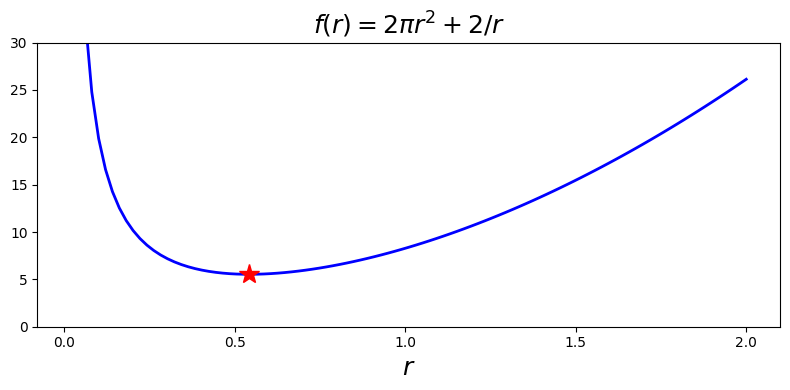

In [18]:
r = np.linspace(0, 2, 100)[1:]

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(r, f(r), lw=2, color='b')
ax.plot(r_min, f(r_min), 'r*', markersize=15)
ax.set_title(r"$f(r) = 2\pi r^2+2/r$", fontsize=18)
ax.set_xlabel(r"$r$", fontsize=18)
ax.set_xticks([0, 0.5, 1, 1.5, 2])
ax.set_ylim(0, 30)

fig.tight_layout()

### Other examples

In [19]:
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1

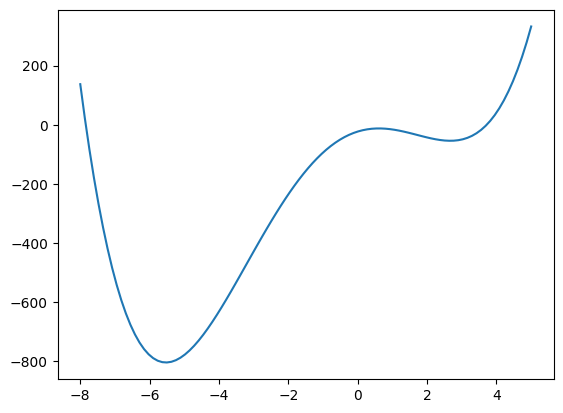

In [20]:
x = np.linspace(-8, 5, 100)
plt.plot(x, f(x));

```scipy.optimize.minimize_scalar``` 함수는 하나의 변수를 가지는 스칼라 함수의 miminum을 찾는데 활용된다.

```scipy.optimize.minimize_scalar(fun, bracket=None, bounds=None, args=(), method='brent', tol=None, options=None)```

In [21]:
optimize.minimize_scalar(f, method='Brent')

     fun: -803.3955308825884
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 17
     nit: 11
 success: True
       x: -5.528801125219663

In [22]:
optimize.minimize_scalar(f, method='bounded', bounds=[0, 6])

     fun: -54.21003937712762
 message: 'Solution found.'
    nfev: 12
     nit: 12
  status: 0
 success: True
       x: 2.668865104039653

함수가 수많은 local minima를 가지는 예제를 살펴보자.

In [23]:
def f(x, offset):
    return -np.sinc(x-offset)

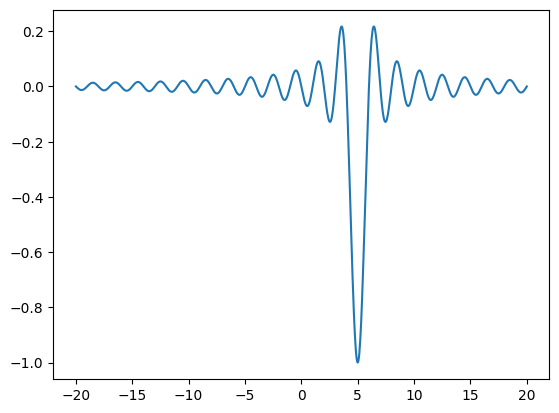

In [24]:
x = np.linspace(-20, 20, 1000)
plt.plot(x, f(x, 5));

In [25]:
sol = optimize.minimize_scalar(f, args=(5,))  # extra argument for f, i.e., offset = 5
sol

     fun: -0.049029624014074166
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 15
     nit: 10
 success: True
       x: -1.4843871263953001

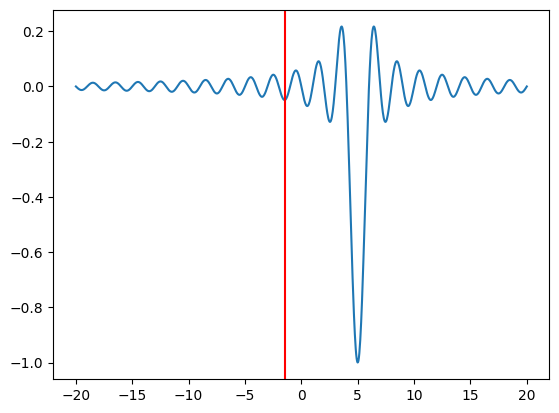

In [26]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red')
plt.show()

여러 랜덤 start 값들을 시도해 볼 수 있다.

In [27]:
lower = np.random.uniform(-20, 20, 100)
upper = lower + 1
sols = [optimize.minimize_scalar(f, args=(5,), bracket=(l, u)) for (l, u) in zip(lower, upper)]

In [28]:
idx = np.argmin([sol.fun for sol in sols])
sol = sols[idx]
sol

     fun: -1.0
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 13
     nit: 9
 success: True
       x: 5.00000000030799

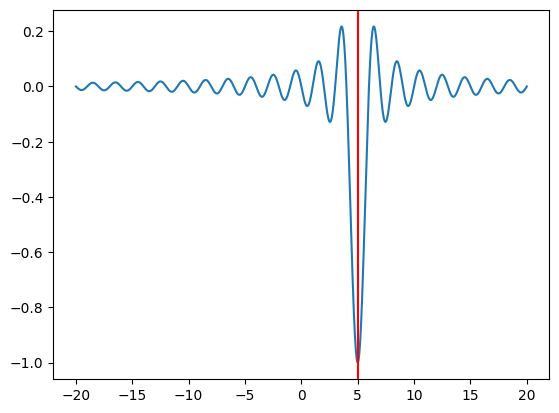

In [29]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red');

확률적 방법인 ```scipy.optimize.basinhopping``` 방법이 해결법이 될 수도 있다.  물론 항상 global minimum을 찾을 수 있는 것은 아니다.

In [30]:
x0 = 0
sol = optimize.basinhopping(f, x0, stepsize=1, minimizer_kwargs={'args': (5,)})
sol

                        fun: -1.0
 lowest_optimization_result:       fun: -1.0
 hess_inv: array([[0.30396794]])
      jac: array([1.49011612e-08])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([4.99999999])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1280
                        nit: 100
                       njev: 640
                    success: True
                          x: array([4.99999999])

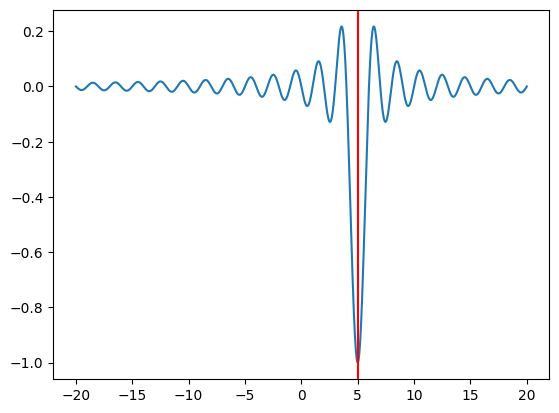

In [31]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red');
plt.show()

### Unconstrained multivariate optimization with multiple variable

In [32]:
x1, x2 = sympy.symbols("x_1, x_2")
f_sym = (x1-1)**4 + 5 * (x2-1)**2 - 2*x1*x2
f_sym

-2*x_1*x_2 + (x_1 - 1)**4 + 5*(x_2 - 1)**2

In [33]:
fprime_sym = [f_sym.diff(x_) for x_ in (x1, x2)]
fprime_sym

[-2*x_2 + 4*(x_1 - 1)**3, -2*x_1 + 10*x_2 - 10]

In [34]:
# Gradient matrix
sympy.Matrix(fprime_sym)

Matrix([
[-2*x_2 + 4*(x_1 - 1)**3],
[   -2*x_1 + 10*x_2 - 10]])

In [35]:
fhess_sym = [[f_sym.diff(x1_, x2_) for x1_ in (x1, x2)] for x2_ in (x1, x2)]
fhess_sym

[[12*(x_1 - 1)**2, -2], [-2, 10]]

In [36]:
# Hessian
sympy.Matrix(fhess_sym)

Matrix([
[12*(x_1 - 1)**2, -2],
[             -2, 10]])

In [37]:
f_lmbda = sympy.lambdify((x1, x2), f_sym, 'numpy')
fprime_lmbda = sympy.lambdify((x1, x2), fprime_sym, 'numpy')
fhess_lmbda = sympy.lambdify((x1, x2), fhess_sym, 'numpy')

In [38]:
def func_XY_X_Y(f):
    """
    Wrapper for f(X) -> f(X[0], X[1])
    """
    return lambda X: np.array(f(X[0], X[1]))

In [39]:
f = func_XY_X_Y(f_lmbda)
fprime = func_XY_X_Y(fprime_lmbda)
fhess = func_XY_X_Y(fhess_lmbda)

```scipy.optimize.fmin_ncg```는 Newton-CG 방법으로 minimum을 찾는다.

```scipy.optimize.fmin_ncg(f, x0, fprime, fhess_p=None, fhess=None, args=(), avextol=1e-05, epsilon=1.4901161193847656e-08, maxiter=None, full_output=0, disp=1, retall=0, callback=None)```

In [40]:
X_opt = optimize.fmin_ncg(f, (0, 0), fprime=fprime, fhess=fhess)
X_opt

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
         Hessian evaluations: 8


array([1.88292613, 1.37658523])

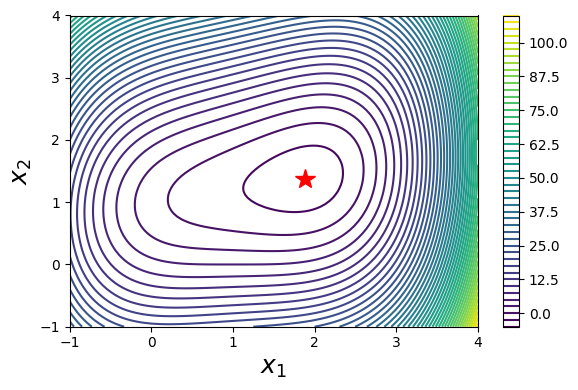

In [41]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 4, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, f_lmbda(X, Y), 50)
ax.plot(X_opt[0], X_opt[1], 'r*', markersize=15)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)
fig.tight_layout()

실제 문제에서는 많은 경우 gradient나 Hessian을 유도하지 못하는 경우가 많다.   

이 경우 gradient나 Hessian을 수치적으로 추정하는데, BFGS 방법과 conjugate gradient method 등이 있다.   

BFGS는 quasi-Newton 방법으로 불리우며, 수치적으로 Hessian이나 gradient를 계산한다.    

Conjugate gradient method는 steepest descent method의 한 벙법으로 Hessian을 이용하지는 않는다.  

```scipy.optimize.fmin_bfgs(f, x0, fprime=None, args=(), gtol=1e-05, norm=inf, epsilon=1.4901161193847656e-08, maxiter=None, full_output=0, disp=1, retall=0, callback=None)```

In [42]:
x_opt = optimize.fmin_bfgs(f, (0, 0), fprime=fprime)
x_opt

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 9
         Function evaluations: 13
         Gradient evaluations: 13


array([1.88292645, 1.37658596])

In [43]:
x_opt = optimize.fmin_cg(f, (0, 0), fprime=fprime)
x_opt

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


array([1.88292612, 1.37658523])

In [44]:
x_opt = optimize.fmin_bfgs(f, (0, 0))
x_opt

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 9
         Function evaluations: 39
         Gradient evaluations: 13


array([1.88292644, 1.37658595])

### Brute force search for initial point

최적화로 찾은 minimum이 global minimum인지 local minimum인지 확실히 확인하기는 힘들다.  
Local minimum이 많은 문제에서 ```optimize.brute```로 시작점을 찾는 것이 도움이 될 수 있다.  

다음 함수는 local minimum이 많다.
$$ 4 \sin (\pi x) + 6 \sin (\pi y) + (x - 1)^2 + (y-1)^2 $$

In [45]:
def f(X):
    x, y = X
    return (4 * np.sin(np.pi * x) + 6 * np.sin(np.pi * y)) + (x - 1)**2 + (y - 1)**2

In [46]:
x_start = optimize.brute(f, (slice(-3, 5, 0.5), slice(-3, 5, 0.5)), finish=None)
x_start

array([1.5, 1.5])

In [47]:
f(x_start)

-9.5

In [48]:
x_opt = optimize.fmin_bfgs(f, x_start)
x_opt

Optimization terminated successfully.
         Current function value: -9.520229
         Iterations: 4
         Function evaluations: 21
         Gradient evaluations: 7


array([1.47586906, 1.48365787])

In [49]:
def func_X_Y_to_XY(f, X, Y):
    s = np.shape(X)
    return f(np.vstack([X.ravel(), Y.ravel()])).reshape(*s)

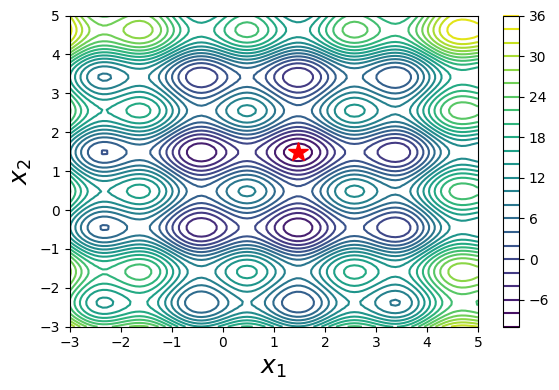

In [50]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-3, 5, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 25)
ax.plot(x_opt[0], x_opt[1], 'r*', markersize=15)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)
fig.tight_layout()

### Nonlinear least square problem

Least square optimization 문제는 objective function 
$$ g(\beta) = \sum_{i=1}^{m} r_i(\beta)^2 $$
를 최소화하는 문제라고 볼 수 있다. 
여기서 
$$r_i(\beta) = y_i - f(x_i, \beta)$$
이다.

SciPy의 ```optimize.leastsq```는 nonlinear least square 문제에 특화되어 있다.

In [51]:
def f(x, beta0, beta1, beta2):
    return beta0 + beta1 * np.exp(-beta2 * x**2)

In [52]:
beta = (0.25, 0.75, 0.5)
xdata = np.linspace(0, 5, 50)
y = f(xdata, *beta)

In [53]:
ydata = y + 0.05 * np.random.randn(len(xdata))

In [54]:
def g(beta):
    return ydata - f(xdata, *beta)

In [55]:
beta_start = (1, 1, 1)

In [56]:
beta_opt, beta_cov = optimize.leastsq(g, beta_start)
beta_opt

array([0.23470183, 0.78559174, 0.56116955])

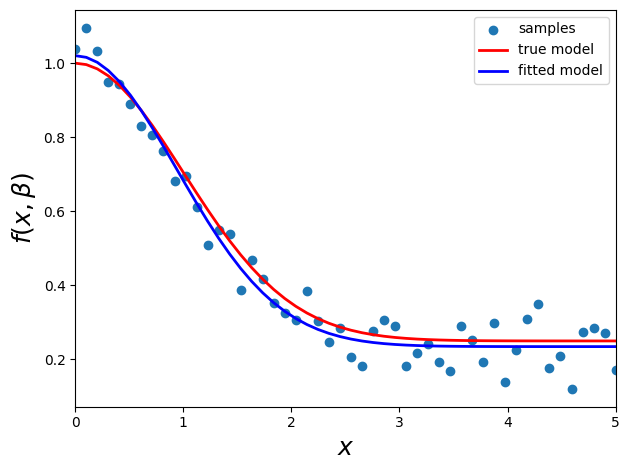

In [57]:
fig, ax = plt.subplots()

ax.scatter(xdata, ydata, label="samples")
ax.plot(xdata, y, 'r', lw=2, label="true model")
ax.plot(xdata, f(xdata, *beta_opt), 'b', lw=2, label="fitted model")
ax.set_xlim(0, 5)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$f(x, \beta)$", fontsize=18)
ax.legend()
fig.tight_layout()

Nonlinear least square 방법으로 ```optimize.curve_fit```을 이용할 수도 있다.

In [58]:
beta_opt, beta_cov = optimize.curve_fit(f, xdata, ydata)
beta_opt

array([0.23470183, 0.78559174, 0.56116955])

일반적인 BFGS 방법으로도 가능하다.

In [59]:
def g2(beta):
    return np.sum((ydata - f(xdata, *beta))**2)

In [60]:
g2((1,1,1))

29.21151572358666

In [61]:
beta_opt_bfgs = optimize.fmin_bfgs(g2, (1, 1, 1))
beta_opt_bfgs

Optimization terminated successfully.
         Current function value: 0.126963
         Iterations: 11
         Function evaluations: 52
         Gradient evaluations: 13


array([0.23470184, 0.78559179, 0.56116978])

### Constrained optimization

제약 조건은 최적화 문제를 더욱 어렵게 한다.  

가장 간단한 제약 조건은 변수의 값이 $0 \leq x \leq 1$처럼 위아래로 bound 된 경우이다. (Box constraint)

이러한 제약 조건 문제는 L-BFGS-B 방법으로 해결할 수 있다.

```optimize.fmin_l_bfgs_b```를 이용하거나 ```optimize.minimize```에 ```method``` 인자로 ```'L-BFGS-B```를 이용한다. 

아래 예제에서는

$$ f(x) = (x_1 - 1)^2 - (x_2 - 1)^2 \text{ subject to } 2 \leq x_1 \leq 3, 0 \leq x_2 \leq 2 $$

를 해결한다.

In [62]:
def f(X):
    x, y = X
    return (x-1)**2 + (y-1)**2

In [63]:
# unconstrained optimization
x_opt = optimize.minimize(f, [0, 0], method='BFGS').x

In [64]:
bnd_x1, bnd_x2 = (2, 3), (0, 2)
x_cons_opt = optimize.minimize(f, [0, 0], method='L-BFGS-B', bounds=[bnd_x1, bnd_x2]).x

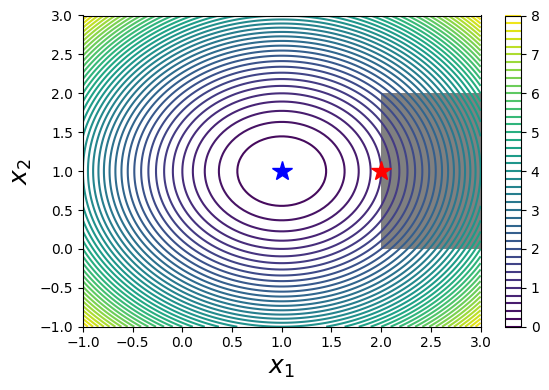

In [65]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'b*', markersize=15)
ax.plot(x_cons_opt[0], x_cons_opt[1], 'r*', markersize=15)
bound_rect = plt.Rectangle((bnd_x1[0], bnd_x2[0]), 
                           bnd_x1[1] - bnd_x1[0], bnd_x2[1] - bnd_x2[0],
                           facecolor="grey")
ax.add_patch(bound_rect)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)

fig.tight_layout()

### Lagrange multiplier

Constrained optimization 문제를 해결하는 방법 중의 하나는 Lagrange multiplier 방법이다.

Lagrange multiplier은 추가적으로 변수를 도입하여 constrained optimization 문제를 unconstrained optimization 문제로 바꾼다.

$f(x)$의 최소값을 찾는 문제에서, $g(x)=0$의 제약 조건이 있다고 하자.

이 문제는 어떤 상수 $\lambda$에 대해 $\nabla f(x) = - \lambda \nabla g(x)$를 푸는 문제와 같다.

한편 $ \mathcal{L}(x) = f(x) - \lambda g(x)$를 Lagrange function이라고 부른다.

직육면체의 겉넓이를 1로 유지하면서 부피를 최대화하는 문제를 생각해 보자.

In [66]:
x = x0, x1, x2, l = sympy.symbols("x_0, x_1, x_2, lambda")
f = x0 * x1 * x2  # 부피 (volume)

아래는 겉넓이가 1이라는 제약조건을 의미한다.

In [67]:
g = 2 * (x0 * x1 + x1 * x2 + x2 * x0) - 1   

In [68]:
# Lagrnage function
L = f + l * g

In [69]:
grad_L = [sympy.diff(L, x_) for x_ in x]
grad_L

[lambda*(2*x_1 + 2*x_2) + x_1*x_2,
 lambda*(2*x_0 + 2*x_2) + x_0*x_2,
 lambda*(2*x_0 + 2*x_1) + x_0*x_1,
 2*x_0*x_1 + 2*x_0*x_2 + 2*x_1*x_2 - 1]

In [70]:
sols = sympy.solve(grad_L)
sols

[{lambda: -sqrt(6)/24, x_0: sqrt(6)/6, x_1: sqrt(6)/6, x_2: sqrt(6)/6},
 {lambda: sqrt(6)/24, x_0: -sqrt(6)/6, x_1: -sqrt(6)/6, x_2: -sqrt(6)/6}]

변의 길이는 양수여야 하기 때문에 ```lambda: -sqrt(6)/24, x_0: sqrt(6)/6, x_1: sqrt(6)/6, x_2: sqrt(6)/6```가 우리가 찾는 해이다.

In [71]:
x0.subs(sols[0]).evalf(), x1.subs(sols[0]).evalf(), x2.subs(sols[0]).evalf()

(0.408248290463863, 0.408248290463863, 0.408248290463863)

In [72]:
g.subs(sols[0])

0

In [73]:
f.subs(sols[0])

sqrt(6)/36

In [74]:
[grad_Li.subs(sols[0]) for grad_Li in grad_L]

[0, 0, 0, 0]

```optimize```의 ```SLSQP```라는 numerical solver를 이용하여 같은 결과를 얻을 수 있다.

In [75]:
# taking minus
def f(X):
    return -X[0] * X[1] * X[2]

In [76]:
def g(X):
    return 2 * (X[0]*X[1] + X[1] * X[2] + X[2] * X[0]) - 1

$g(x) = 0$의 형태의 제약 조건

In [77]:
constraints = [dict(type='eq', fun=g)]
constraints 

[{'type': 'eq', 'fun': <function __main__.g(X)>}]

In [78]:
result = optimize.minimize(f, [0.5, 1, 1.5], method='SLSQP', constraints=constraints)

In [79]:
result

     fun: -0.06804136862287297
     jac: array([-0.16666925, -0.16666542, -0.16666526])
 message: 'Optimization terminated successfully'
    nfev: 77
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([0.40824188, 0.40825127, 0.40825165])

### Inequality constraint

```type='ineq'```를 이용하여 inequality constraint 문제를 해결한다.

In [80]:
def f(X):
    return (X[0] - 1)**2 + (X[1] - 1)**2

$g(x) = x_1 - 1.75 - (x_0 - 0.75)^4$

In [81]:
def g(X):
    return X[1] - 1.75 - (X[0] - 0.75)**4

$g(x) \geq 0$의 형태의 제약 조건

In [82]:
constraints = [dict(type='ineq', fun=g)]

비교를 위해 unconstraint optimization을 진행해 본다.

In [83]:
x_opt = optimize.minimize(f, (0, 0), method='BFGS').x
x_opt

array([0.99999999, 0.99999999])

constraint optimization

In [84]:
x_cons_opt = optimize.minimize(f, (0, 0), method='SLSQP', constraints=constraints).x
x_cons_opt

array([0.96857656, 1.75228252])

In [85]:
x_cons_opt2 = optimize.minimize(f, (0, 0), method='COBYLA', constraints=constraints).x
x_cons_opt2 

array([0.96865024, 1.75228559])

아래 그림에서 진한 부분은 제약 조건이 만족하는 영역을 나타낸다.

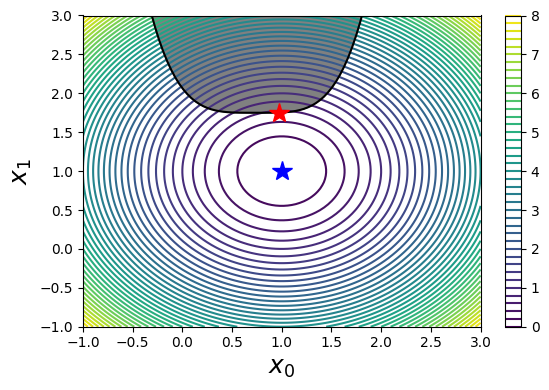

In [86]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'b*', markersize=15)

ax.plot(x_, 1.75 + (x_-0.75)**4, 'k-', markersize=15)
ax.fill_between(x_, 1.75 + (x_-0.75)**4, 3, color="grey")
ax.plot(x_cons_opt[0], x_cons_opt[1], 'r*', markersize=15)

ax.set_ylim(-1, 3)
ax.set_xlabel(r"$x_0$", fontsize=18)
ax.set_ylabel(r"$x_1$", fontsize=18)
plt.colorbar(c, ax=ax)

fig.tight_layout()

### Linear programming

Objective function과 constraint가 모두 linear 함수로 이루어진 optimization 문제를 linear programming이라 한다.

$$ \min_x c^{\top} x \text{ subject to } Ax \leq b \text{ and } x \geq 0 $$.

예를 들어, objective function은 $f(x) = - x_0 + 2 x_1 - 3 x_2$이고, 제약 조건은 $x_0 + x_1 \leq 1, - x_0 + 3 x_1 \leq 2, -x_1 + x_2 \leq 3 $이라고 하자.

In [87]:
c = np.array([-1.0, 2.0, -3.0])

A = np.array([[ 1.0, 1.0, 0.0],
              [-1.0, 3.0, 0.0],
              [ 0.0, -1.0, 1.0]])

b = np.array([1.0, 2.0, 3.0])

이 문제를 풀기위해 ```cvxopt.solvers.lp```를 이용한다.

```cvxopt```에서는 행렬과 벡터를 표현하는 고유의 클래스들을 사용하기에 다음의 변환을 이용한다.

In [88]:
A_ = cvxopt.matrix(A)
b_ = cvxopt.matrix(b)
c_ = cvxopt.matrix(c)

In [89]:
sol = cvxopt.solvers.lp(c_, A_, b_)
sol

Optimal solution found.


{'x': <3x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <3x1 matrix, tc='d'>,
 'z': <3x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 0.0,
 'relative gap': 0.0,
 'primal objective': -10.0,
 'dual objective': -10.0,
 'primal infeasibility': 0.0,
 'primal slack': -0.0,
 'dual slack': 0.0,
 'dual infeasibility': 1.4835979218054372e-16,
 'residual as primal infeasibility certificate': None,
 'residual as dual infeasibility certificate': None,
 'iterations': 0}

In [90]:
x = np.array(sol['x'])
x

array([[0.25],
       [0.75],
       [3.75]])

In [91]:
#f(x)의 값
sol['primal objective']

-10.0